In [1]:
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing

%matplotlib inline

In [2]:
np.random.seed(123)

## inspeect data

In [3]:
%%time 

data = pd.read_csv("../../../data/data.csv", parse_dates=["date_time"])

CPU times: user 37.4 s, sys: 4.86 s, total: 42.3 s
Wall time: 42.3 s


In [4]:
data = data[
    ["date_time", "zone_id", "banner_id", "campaign_clicks", "os_id", "country_id", "impressions", "clicks"]
]

In [5]:
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30,0,0,0,0,0,1,1
1,2021-09-26 22:54:49,1,1,0,0,1,1,1
2,2021-09-26 23:57:20,2,2,3,0,0,1,1
3,2021-09-27 00:04:30,3,3,0,1,1,1,1
4,2021-09-27 00:06:21,4,4,0,1,0,1,1


In [6]:
data.describe()

,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
count,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,15821472.0,1.582147e+07
mean,8.152679e+01,3.816483e+02,6.238540e-01,1.840605e+00,4.346986e+00,1.0,2.668835e-02
std,1.632448e+02,3.959386e+02,9.249152e+00,1.530005e+00,4.317701e+00,0.0,1.611710e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00
25%,1.400000e+01,5.200000e+01,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000e+00
50%,1.900000e+01,2.170000e+02,0.000000e+00,2.000000e+00,4.000000e+00,1.0,0.000000e+00
75%,6.000000e+01,6.110000e+02,0.000000e+00,3.000000e+00,7.000000e+00,1.0,0.000000e+00
max,3.443000e+03,1.632000e+03,8.290000e+02,1.000000e+01,1.600000e+01,1.0,1.000000e+00


In [7]:
data.date_time.min(), data.date_time.max()

(Timestamp('2021-09-01 00:02:49'), Timestamp('2021-10-02 23:59:59'))

## Extract day

In [8]:
data["day"] = (data.date_time - pd.datetime(2021,9,1)).dt.days

/var/tmp/ipykernel_24099/813304573.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  data["day"] = (data.date_time - pd.datetime(2021,9,1)).dt.days


In [9]:
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks,day
0,2021-09-27 00:01:30,0,0,0,0,0,1,1,26
1,2021-09-26 22:54:49,1,1,0,0,1,1,1,25
2,2021-09-26 23:57:20,2,2,3,0,0,1,1,25
3,2021-09-27 00:04:30,3,3,0,1,1,1,1,26
4,2021-09-27 00:06:21,4,4,0,1,0,1,1,26


In [10]:
data.day.min(), data.day.max()

(0, 31)

<AxesSubplot:>

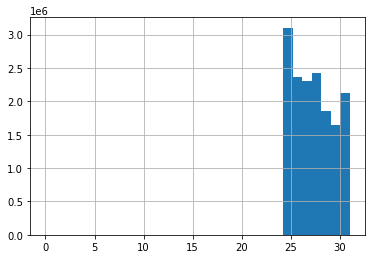

In [11]:
data.day.hist(bins=32)

<AxesSubplot:>

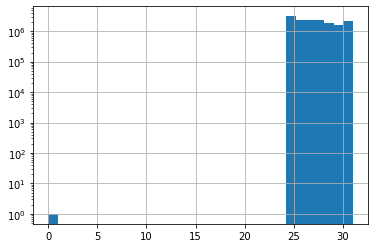

In [12]:
data.day.hist(bins=32, log=True)

In [13]:
data.day.describe()

count    1.582147e+07
mean     2.769505e+01
std      2.039576e+00
min      0.000000e+00
25%      2.600000e+01
50%      2.800000e+01
75%      2.900000e+01
max      3.100000e+01
Name: day, dtype: float64

## There is one outlier:

In [14]:
data[data.day <= 24]

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks,day
1390198,2021-09-01 00:02:49,30,596,0,0,7,1,0,0


## Remove the outlier

In [15]:
data.drop(data[data.day <= 24].index, inplace=True)

In [16]:
data.date_time.min(), data.date_time.max(), data.day.min(), data.day.max()

(Timestamp('2021-09-26 00:00:00'), Timestamp('2021-10-02 23:59:59'), 25, 31)

In [17]:
data.day -= 25

<AxesSubplot:>

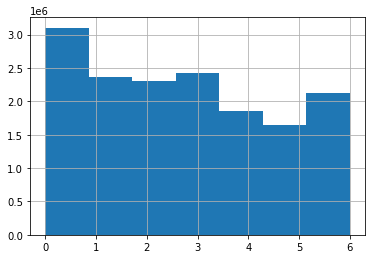

In [18]:
data.day.hist(bins=7)

In [19]:
categorical_columns = ["zone_id", "banner_id", "os_id", "country_id"]

In [20]:
for colname in categorical_columns:
    print(colname, data[colname].min(), data[colname].max())
    data[colname] = data[colname].astype(
        pd.api.types.CategoricalDtype(range(data[colname].max() - data[colname].min() + 1))
    )

zone_id 0 3443
banner_id 0 1632
os_id 0 10
country_id 0 16


In [21]:
data.describe(include='all')

/var/tmp/ipykernel_24099/1336221646.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe(include='all')


,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks,day
count,15821471,15821471.0,15821471.0,1.582147e+07,15821471.0,15821471.0,15821471.0,1.582147e+07,1.582147e+07
unique,604711,3444.0,1633.0,NaN,11.0,17.0,NaN,NaN,NaN
top,2021-09-29 19:14:40,17.0,22.0,NaN,2.0,0.0,NaN,NaN,NaN
freq,140,2280422.0,613367.0,NaN,4589979.0,4956393.0,NaN,NaN,NaN
first,2021-09-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2021-10-02 23:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,6.238540e-01,NaN,NaN,1.0,2.668835e-02,2.695049e+00
std,NaN,NaN,NaN,9.249152e+00,NaN,NaN,0.0,1.611710e-01,2.039565e+00
min,NaN,NaN,NaN,0.000000e+00,NaN,NaN,1.0,0.000000e+00,0.000000e+00
25%,NaN,NaN,NaN,0.000000e+00,NaN,NaN,1.0,0.000000e+00,1.000000e+00


## train dev test split

In [22]:
train = data[data.day <= 4]
dev = data[data.day == 5]
test = data[data.day == 6]
test_feats = test.drop("clicks", axis='columns')

len(train), len(dev), len(test), len(test_feats)

(12049045, 1643448, 2128978, 2128978)

In [23]:
test_feats.columns

Index(['date_time', 'zone_id', 'banner_id', 'campaign_clicks', 'os_id',
       'country_id', 'impressions', 'day'],
      dtype='object')

## Prepare baseline

In [24]:
train.clicks.mean(), dev.clicks.mean()

(0.02308797087238034, 0.04180174851896744)

## Predict constant learned from train

In [25]:
metrics.log_loss(dev.clicks, [0.02308797087238034] * len(dev))

0.17990976856673876

In [26]:
metrics.log_loss(test.clicks, [0.02308797087238034] * len(test))

0.15592795520192157

## Predict constant learned from dev

In [27]:
metrics.log_loss(dev.clicks, [0.04180174851896744] * len(dev))

0.1736285268660261

In [28]:
metrics.log_loss(test.clicks, [0.04180174851896744] * len(test))

0.15357188282131304

## Clicks depend on banner_id:

<AxesSubplot:>

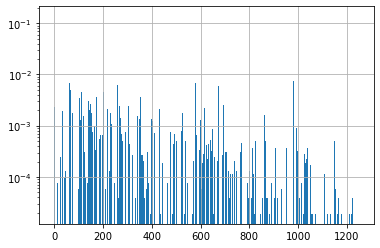

In [29]:
dev[dev.clicks == 1].banner_id.hist(bins=1633, density=True, log=True)

<AxesSubplot:>

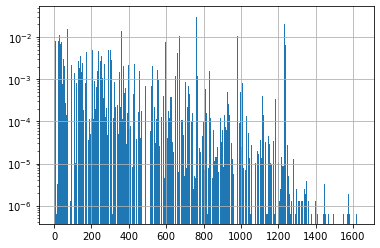

In [30]:
dev[dev.clicks == 0].banner_id.hist(bins=1633, density=True, log=True)

## Predict separate constant for each banner_id

In [31]:
banner_id2clicks = train.groupby("banner_id").clicks.mean()

In [32]:
# predict average click ratio for unknown banner_id
banner_id2clicks[banner_id2clicks.isna()] = 0.04180174851896744

## Better for dev but worse for test

In [33]:
metrics.log_loss(
    dev.clicks,
    dev.join(banner_id2clicks, on="banner_id", rsuffix="_banner_id").clicks_banner_id
)

0.1635688979134283

In [34]:
metrics.log_loss(
    test.clicks,
    test_feats.join(banner_id2clicks, on='banner_id').clicks
)

0.1560167297399033

## Apply logistic regression with liblinear optimizer for 'zone_id', 'banner_id', 'os_id', 'country_id'

In [35]:
categorical_columns

['zone_id', 'banner_id', 'os_id', 'country_id']

In [36]:
X_train_cat = train[categorical_columns].to_numpy()

In [37]:
ohe = preprocessing.OneHotEncoder(categories=[range(3444), range(1633), range(11), range(17)])

In [38]:
ohe.fit(X_train_cat)

OneHotEncoder(categories=[range(0, 3444), range(0, 1633), range(0, 11),
                          range(0, 17)])

In [39]:
X_train = ohe.transform(X_train_cat)

In [40]:
X_train.shape

(12049045, 5105)

In [41]:
model = linear_model.LogisticRegression(solver='liblinear')

In [42]:
shuffled_train_idxs = list(range(len(train)))
np.random.shuffle(shuffled_train_idxs)

In [43]:
%%time
model.fit(X_train[shuffled_train_idxs[:2000000]], train.clicks.to_numpy()[shuffled_train_idxs[:2000000]])

CPU times: user 1min 25s, sys: 3.25 s, total: 1min 29s
Wall time: 34.1 s


LogisticRegression(solver='liblinear')

In [44]:
X_dev = ohe.transform(dev[categorical_columns].to_numpy())

In [45]:
%%time
dev_predict = model.predict_proba(X_dev)

CPU times: user 59.8 ms, sys: 15.6 ms, total: 75.4 ms
Wall time: 72.1 ms


In [46]:
metrics.log_loss(dev.clicks, dev_predict)

0.15287545717148104

In [47]:
X_test = ohe.transform(test_feats[categorical_columns].to_numpy())
test_predict = model.predict_proba(X_test)
metrics.log_loss(test.clicks, test_predict)

0.13597807111968535

## Apply logistic regression with liblinear optimizer for 'zone_id', 'banner_id', 'os_id', 'country_id', regularization and interactions banner_Id : os_id and banner_id : country_id

In [48]:
def make_features_with_interactions(df):
    feats = np.zeros((df.shape[0], 6))
    feats[:, :4] = df[categorical_columns].to_numpy()
    
    # interaction banner_id (idx=1, cnt=1633) x os_id (idx=2, cnt=11)
    feats[:, 4] = feats[:, 1] * 11 + feats[:, 2]
    
    # interaction banner_id (idx=1, cnt=1633) x country_id (idx=3, cnt=17)
    feats[:, 5] = feats[:, 1] * 17 + feats[:, 3]
    
    return feats

In [49]:
%%time
X_train_cat_with_interactions = make_features_with_interactions(train)

CPU times: user 1.06 s, sys: 724 ms, total: 1.78 s
Wall time: 1.78 s


In [50]:
X_train_cat_with_interactions[:10]

array([[  0.,   0.,   0.,   0.,   0.,   0.],
       [  1.,   1.,   0.,   1.,  11.,  18.],
       [  2.,   2.,   0.,   0.,  22.,  34.],
       [  3.,   3.,   1.,   1.,  34.,  52.],
       [  4.,   4.,   1.,   0.,  45.,  68.],
       [  5.,   5.,   2.,   2.,  57.,  87.],
       [  6.,   6.,   3.,   0.,  69., 102.],
       [  7.,   7.,   4.,   1.,  81., 120.],
       [  8.,   8.,   4.,   3.,  92., 139.],
       [  1.,   9.,   4.,   4., 103., 157.]])

In [51]:
ohe = preprocessing.OneHotEncoder(
    categories=[range(3444), range(1633), range(11), range(17), range(1633 * 11), range(1633 * 17)]
)

In [52]:
ohe.fit(X_train_cat_with_interactions)

OneHotEncoder(categories=[range(0, 3444), range(0, 1633), range(0, 11),
                          range(0, 17), range(0, 17963), range(0, 27761)])

In [53]:
X_train_wi = ohe.transform(X_train_cat_with_interactions)

In [54]:
model = linear_model.LogisticRegression(solver='liblinear', C=0.3)

In [55]:
%%time
model.fit(X_train_wi[shuffled_train_idxs[:2000000]], train.clicks.to_numpy()[shuffled_train_idxs[:2000000]])

CPU times: user 12min 39s, sys: 44.3 s, total: 13min 23s
Wall time: 38.6 s


LogisticRegression(C=0.3, solver='liblinear')

In [56]:
%%time
dev_predict = model.predict_proba(ohe.transform(make_features_with_interactions(dev)))

CPU times: user 3.19 s, sys: 314 ms, total: 3.5 s
Wall time: 2.08 s


In [57]:
metrics.log_loss(dev.clicks, dev_predict)

0.15271435387517487

In [58]:
test_predict = model.predict_proba(ohe.transform(make_features_with_interactions(test_feats)))
metrics.log_loss(test.clicks, test_predict)

0.1358300575329168